In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [375]:
## STARTING OF Pytorch-replica(confuses github copilot) ENGINE
from typing import Any

class Value:
    pass

class Value:
    def __init__(self, data: Any, _children: tuple[Value] = (), _op: str = "", label:str = "", grad:float = 0.0):
        if isinstance(data, Value):
            raise TypeError("Value cannot be initialized with another Value instance")
        self.data = data
        self._children = _children
        self._op = _op
        self.label = label
        self.grad = grad
        self._backward = None

    def __repr__(self)->str:
        return f"Value(data={self.data :0.04f}, label = {self.label})"#, _children={self._children}, _op='{self._op}')"
    
    def __add__(self, other:Value)->Value:
        if not isinstance(other, Value):
            other = Value(other)
        def _backward(parent_data:float,parent_grad:float = 1.0):
                other.grad += (1.0* parent_grad)
                self.grad += (1.0 * parent_grad)

        out = Value(self.data + other.data, _children=(self, other), _op='+')
        out._backward = _backward
        return out
    
    def __sub__(self, other:Value)->Value:
        if not isinstance(other, Value):
            other = Value(other)
        def _backward(parent_data:float,parent_grad:float = 1.0):
            self.grad = 1.0*parent_grad
            other.grad = -1.0*parent_grad
        out = Value(self.data-other.data, _children = (self,other), _op='-')
        out._backward = _backward
        return out

    
    def __mul__(self, other:Any)->Value:
        if not isinstance(other, Value):
            other = Value(other)
        def _backward(parent_data:float,parent_grad:float = 1.0):
            self.grad += (other.data*parent_grad)
            other.grad += (self.data*parent_grad)

        out = Value(self.data * other.data, _children=(self, other), _op='*')
        out._backward = _backward
        return out
    
    def __pow__(self, other:Any)->Value:
        if not isinstance(other, Value):
            other = Value(other)
        def _backward(parent_data:float,parent_grad:float = 1.0):
            self.grad = (other.data* self.data**(other.data -1.0)) * parent_grad

        out = Value(self.data ** other.data, _children=(self, ), _op='**')
        out._backward = _backward
        return out
    

    def __radd__(self, other:Any)->Value:
        return self + other
    
    def __rsub__(self, other:Any)->Value:
        return self-other
    
    def __rmul__(self, other:Any)->Value:
        return self*other
    
    def tanh(self)->Value:
        tanh = (1 - math.exp(-2*self.data))/(1+math.exp(-2*self.data))
        def _backward(parent_data:float,parent_grad:float = 1.0):
            self.grad += (1-tanh**2)*parent_grad

        out = Value(tanh, _children = (self,), _op = "tanh")
        out._backward=_backward
        return out
    
    def backward(self)->None:
        def _backward(node:Value):
            if not node._children:
                return None
            node._backward(parent_data= node.data, parent_grad=node.grad)
            for child in node._children:
                _backward(child)
        self.grad = 1.0
        _backward(self)
                


In [376]:
#Single hidden layer mlp with two hidden neurons and one output neuron
def mlp():
    x1 = Value(2.0, label = 'x1')
    x2 = Value(3.0, label = 'x2')

    w11 = Value(0.4, label='w11')
    w21 = Value(0.2, label = 'w21')

    b1 = Value(0.01, label = 'b1')

    v1 = x1*w11; v1.label = 'x1w11'
    v2 = x2*w21; v2.label = 'x2w21'

    #Hidden layer
    h1 = v1 + v2; h1.label = 'x1w11+x2w21'
    n = h1 + b1; n.label = 'x1w11+x2w21+b1'
    o1 = n.tanh(); o1.label = 'o1'
    return o1

op = mlp()

In [377]:
# Expression graph visualization

from graphviz import Digraph
from typing import Union

def trace(root:Value)->Union[set[Value],set[tuple[Value, Value]]]:
    nodes, edges = set(), set()
    def build(v:Value):
        if v not in nodes:
            nodes.add(v)
            for child in v._children:
                edges.add((v,child))
                build(child)
    build(root)
    return nodes, edges

def draw_graph(root:Value):
    graph = Digraph(name="Expression graph", format = "svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    op_id_dict, node_id_dict = dict(), dict()
    for node in nodes:
        node_id = str(id(node))
        node_id_dict[node] = node_id
        graph.node(node_id, label = f"{node.label}|data={node.data:0.4f}| grad={node.grad:0.4f}", shape = "record")
        if node._op:
            #create op node
            op_node_id = node_id + "_op"
            op_id_dict[node] = op_node_id
            graph.node(op_node_id, label = node._op)
            graph.edge(op_node_id, node_id, label = "output")
    #Now connect the children to the operation nodes
    for parent,child in edges:
        if parent._op:
            graph.edge(node_id_dict[child], op_id_dict[parent], label = "input")
    return graph


In [378]:
op.backward()

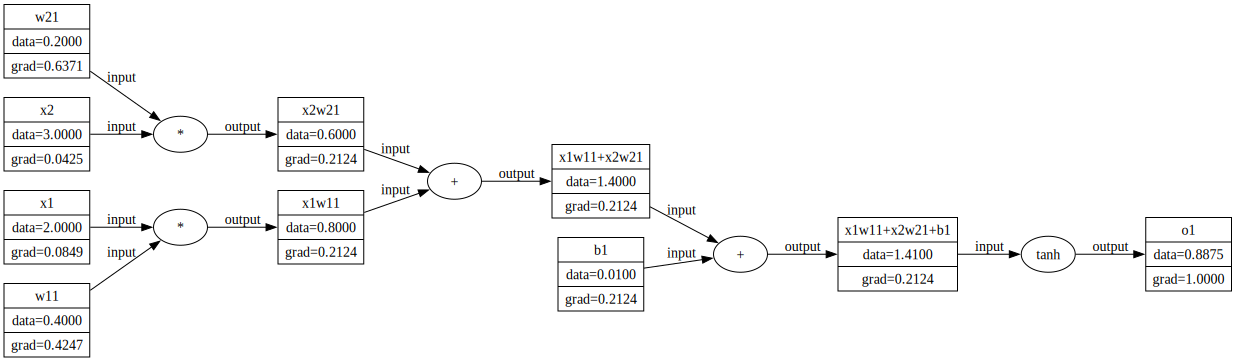

In [379]:
from IPython.display import display
graph = draw_graph(op)
display(graph)

In [380]:
#pytorchifying the code
import torch

In [381]:
#pytorchifying the code
# def mlp_torch():
x1 = torch.tensor([2.0], dtype= torch.float64, requires_grad = True)
x2 = torch.tensor([3.0], dtype=torch.float64, requires_grad = True)

w11 = torch.tensor([0.4], dtype = torch.float64, requires_grad=True)
w21 = torch.tensor([0.2], dtype = torch.float64, requires_grad = True)

b1 = torch.tensor([0.01], dtype = torch.float64, requires_grad=True)

h1 = torch.dot(torch.tensor([x1, x2], dtype=torch.float64), torch.tensor([w11, w21], dtype=torch.float64)) + b1
h1.retain_grad()
o1 = torch.tanh(h1)
o1.retain_grad()


In [382]:
o1

tensor([0.8875], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [383]:
o1.backward(create_graph=True)
print(f"h1 grad:{h1.grad.item():0.04f}, o1.grad:{o1.grad.item():0.04f}")

h1 grad:0.2124, o1.grad:1.0000


In [541]:
#Replicating pytorch's nn.Module
import random

class Neuron:
    def __init__(self, nin:int, neuron_no:int, layer_no:int)->None:
        self.w = [Value(random.uniform(0,1), label = f"w{i}{neuron_no}{layer_no}") for i in range(nin)]
        self.b = Value(random.uniform(0,1), label = f"b{neuron_no}{layer_no}")

    def __repr__(self)->str:
        return f"Neuron(w= {self.w}, b= {self.b})"
    
    def __call__(self, inp:list[Value],neuron_no:int, layer_no:int)->Value:
        res = sum([w*x for w,x in zip(self.w, inp)], self.b)
        res.label = f"dot_prod_{neuron_no}{layer_no}"
        out = res.tanh()
        out.label = f"n{neuron_no}{layer_no}"
        return out
    
    @property
    def parameters(self)->list[Value]:
        return self.w + [self.b]

class MLP:
    def __init__(self, n_layers:list[int]):
        self.n_layers = n_layers
        self.hidden_layers = []
        self.out = []

    def __repr__(self)->str:
        return f"MLP(hidden_layers= {self.hidden_layers}, out= {self.out})"
    
    def create_hidden_layer(self, nin:int, layer_no:int, neuron_count:int)->None:
        self.hidden_layers.append([Neuron(nin, j, layer_no) for j in range(neuron_count)])


    def create_all_hidden_layers(self, inp:list[float])->None:
        inp = [Value(x, label = f"x{i}") for i,x in enumerate(inp)]
        self.n_layers = [len(inp),*self.n_layers]
        for i, neuron_count in enumerate(self.n_layers[1:]):
            self.create_hidden_layer(self.n_layers[i],i, neuron_count)
    
    def __call__(self, inp:list[Value])->Value|list[Value]:
        if not self.hidden_layers:
            self.create_all_hidden_layers(inp)
        input_vec = inp
        for i, hl in enumerate(self.hidden_layers):
            input_vec = [neuron(input_vec, j, i) for j, neuron in enumerate(hl)]
            
        self.out = input_vec[0] if len(input_vec)==1 else input_vec
        return self.out
    
    @property
    def parameters(self)->list[Value]:
        return [p for hl in self.hidden_layers for n in hl for p in n.parameters]

In [542]:
mlp = MLP([2,2,1])

In [543]:
mlp([1,2,3])

Value(data=0.5084, label = n02)

In [ ]:
#Validate child nodes
def recusion_validation(node:Value):
    x=0
    def trace(node):
        nonlocal x
        if not node._children:
            return None
        print(f"recursion :{x}")
        x+=1
        for child in node._children:
            print(node.label , child)
            trace(child)
    trace(node)
recusion_validation(mlp.out)


In [240]:
mlp.out.backward()

In [ ]:
from IPython.display import display
def p_display(node:Value):
    graph = draw_graph(node)
    display(graph)

p_display(mlp.out)

In [306]:
import random
#REIMPLEMENTING ANDREJ'S VERSION USING SEPARATE CLASSES FOR NEURONS AND LAYERS.

class Neuron:
    def __init__(self, nin:int):
        self.w = [Value(random.uniform(0,1)) for _ in range(nin)]
        self.b = Value(random.uniform(0,1))

    def __call__(self, inp:list[Value])->Value:
        res = sum([w*x for w,x in zip(self.w,inp)], self.b)
        out = res.tanh()
        return out

class Layer:
    def __init__(self, nin:int, nout:int)->None:
        self.neurons = [Neuron(nin) for _ in range(nout)]
        self.outs:list[Value] = []
    
    def __call__(self, inp:list[Value])->list[Value]:
        for n in self.neurons:
            self.outs.append(n(inp))
        return self.outs

class MLP:
    def __init__(self, n_layers:list[int])->None:
        self.n_layers =  n_layers
        self.inp = []
        self.layers = []
    
    def create_all_layers(self, inp:list[int])->None:
        self.inp = [Value(x) for x in inp]
        self.n_layers =[len(inp)] + self.n_layers
        for i, nout in enumerate(self.n_layers[1:]):
            self.layers.append(Layer(self.n_layers[i], nout))

    def __call__(self, inp:list[int])->Value:
        if not self.layers:
            self.create_all_layers(inp)
        input_vec = inp
        for layer in self.layers:
            input_vec = layer(input_vec)
        return input_vec[0] if len(input_vec)==1 else input_vec



In [544]:
#Creating a dataset
import json
from pathlib import Path
with open(Path(r"./sample_dataset.json"),'r') as f:
    dataset  = json.load(f)

In [545]:
loss = sum((mlp(inp)-pred)**2 for inp, pred in zip(*dataset.values())); loss.label = 'loss'
loss


Value(data=4.7960, label = loss)

In [547]:
from copy import deepcopy

iters_over = 0
best_loss = (loss,deepcopy(mlp.parameters))
def gradient_descent(max_iters:int = 1000, h:float = 0.01):
    global best_loss
    global loss
    global mlp
    global iters_over
    for param in mlp.parameters:
        param.data-= h*param.grad
        param.grad=0.0
    loss.backward()
    loss = sum((mlp(inp)-pred)**2 for inp, pred in zip(*dataset.values())); loss.label = 'loss'
    if loss.data>best_loss[0].data:
        return
    if iters_over>=max_iters:
        return
    iters_over+=1
    best_loss = (loss,deepcopy(mlp.parameters))
    gradient_descent()
gradient_descent()

In [548]:
loss

Value(data=0.0065, label = loss)

In [549]:
mlp.parameters

[Value(data=1.5641, label = w000),
 Value(data=-0.1206, label = w100),
 Value(data=-0.1308, label = w200),
 Value(data=0.5504, label = b00),
 Value(data=0.7010, label = w010),
 Value(data=0.4554, label = w110),
 Value(data=0.7302, label = w210),
 Value(data=0.9729, label = b10),
 Value(data=1.5282, label = w001),
 Value(data=0.2253, label = w101),
 Value(data=-0.1994, label = b01),
 Value(data=0.7036, label = w011),
 Value(data=0.3115, label = w111),
 Value(data=0.1609, label = b11),
 Value(data=-1.8005, label = w002),
 Value(data=-0.4611, label = w102),
 Value(data=0.0360, label = b02)]

In [ ]:
p_display(loss)